In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def detect_lanes(source_path):
    if not os.path.exists(source_path):
        print(f" File not found: {source_path}")
        return

    if source_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        process_image(source_path)
    elif source_path.lower().endswith(('.mp4', '.avi', '.mov')):
        process_video(source_path)
    else:
        print("Unsupported file format!")

# -------------------- IMAGE PROCESSING --------------------
def process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f" Unable to read image: {image_path}")
        return
    result_img = lane_detection_pipeline(img)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Lane Detection Result")
    plt.axis('off')
    plt.show()

# -------------------- VIDEO PROCESSING --------------------
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f" Unable to open video: {video_path}")
        return

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_lane_video.avi', fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        result = lane_detection_pipeline(frame)
        out.write(result)

        cv2.imshow("Lane Detection", result)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(" Saved output as output_lane_video.avi")

# -------------------- LANE DETECTION PIPELINE --------------------
def lane_detection_pipeline(img):
    original = img.copy()

    # Night time detection and enhancement
    if is_night_frame(img):
        img = enhance_night_frame(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    height, width = img.shape[:2]
    mask = np.zeros_like(edges)
    vertices = np.array([[
        (0, height),
        (width / 2 - 100, height / 2),
        (width / 2 + 100, height / 2),
        (width, height)
    ]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, 255)
    masked_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=30)
    solid_lines, dashed_lines = [], []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            if abs(angle) < 30 or abs(angle) > 150:
                continue
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            if analyze_dash_frequency(masked_edges, (x1, y1, x2, y2)):
                dashed_lines.append(line[0])
            else:
                if length > 100:
                    solid_lines.append(line[0])

        solid_lines = cluster_lines(solid_lines) if solid_lines else []
        dashed_lines = cluster_lines(dashed_lines) if dashed_lines else []
        img = visualize_lanes(img, solid_lines, dashed_lines)
    else:
        warped, M, Minv = perspective_transform(original)
        binary = color_threshold(warped)
        if binary is not None:
            left_fit, right_fit = fit_polynomial(binary)
            if left_fit is not None and right_fit is not None:
                img = draw_lanes(original, binary, left_fit, right_fit, Minv)

    return img



In [2]:
# -------------------- SUPPORT FUNCTIONS --------------------
def is_night_frame(img, threshold=50):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)
    return mean_brightness < threshold

def enhance_night_frame(img):
    # Convert to LAB color space and apply CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Increase contrast slightly
    alpha = 1.3  # Contrast control
    beta = 10    # Brightness control
    enhanced = cv2.convertScaleAbs(enhanced, alpha=alpha, beta=beta)

    return enhanced

def analyze_dash_frequency(binary_img, line_points):
    x1, y1, x2, y2 = line_points
    num_samples = 50
    intensities = []
    for i in range(num_samples):
        x = int(x1 + (x2 - x1) * i / num_samples)
        y = int(y1 + (y2 - y1) * i / num_samples)
        if 0 <= x < binary_img.shape[1] and 0 <= y < binary_img.shape[0]:
            intensities.append(binary_img[y, x])
        else:
            intensities.append(0)
    transitions = sum(abs(int(intensities[i]) - int(intensities[i - 1])) > 100 for i in range(1, len(intensities)))
    return transitions > 5

def cluster_lines(lines, threshold=30):
    clusters = []
    for line in lines:
        matched = False
        for cluster in clusters:
            if np.linalg.norm(line[:2] - cluster['centroid']) < threshold:
                cluster['lines'].append(line)
                cluster['centroid'] = np.mean([l[:2] for l in cluster['lines']], axis=0)
                matched = True
                break
        if not matched:
            clusters.append({'lines': [line], 'centroid': np.array(line[:2])})
    return [np.mean(np.array(cluster['lines']), axis=0).astype(int) for cluster in clusters]

def perspective_transform(img):
    h, w = img.shape[:2]
    src = np.float32([[w * 0.45, h * 0.65], [w * 0.55, h * 0.65], [w * 0.15, h], [w * 0.85, h]])
    dst = np.float32([[w * 0.25, 0], [w * 0.75, 0], [w * 0.25, h], [w * 0.75, h]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w, h))
    return warped, M, Minv

def color_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    white_mask = cv2.inRange(hls, (0, 200, 0), (255, 255, 255))
    yellow_mask = cv2.inRange(hls, (15, 30, 100), (40, 150, 255))
    return cv2.bitwise_or(white_mask, yellow_mask)

def fit_polynomial(binary):
    histogram = np.sum(binary[binary.shape[0] // 2:, :], axis=0)
    midpoint = histogram.shape[0] // 2
    leftx = np.argmax(histogram[:midpoint])
    rightx = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = binary.shape[0] // nwindows
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds, right_lane_inds = [], []

    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window + 1) * window_height
        win_y_high = binary.shape[0] - window * window_height
        win_xleft_low = leftx - margin
        win_xleft_high = leftx + margin
        win_xright_low = rightx - margin
        win_xright_high = rightx + margin
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    if len(left_lane_inds) == 0 or len(right_lane_inds) == 0:
        return None, None
    left_fit = np.polyfit(nonzeroy[left_lane_inds], nonzerox[left_lane_inds], 2)
    right_fit = np.polyfit(nonzeroy[right_lane_inds], nonzerox[right_lane_inds], 2)
    return left_fit, right_fit

def draw_lanes(img, binary, left_fit, right_fit, Minv):
    ploty = np.linspace(0, binary.shape[0] - 1, binary.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

def visualize_lanes(img, solid_lines, dashed_lines):
    result = img.copy()
    for line in solid_lines:
        cv2.line(result, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 5)
    for line in dashed_lines:
        cv2.line(result, (line[0], line[1]), (line[2], line[3]), (255, 0, 0), 5)
    return result


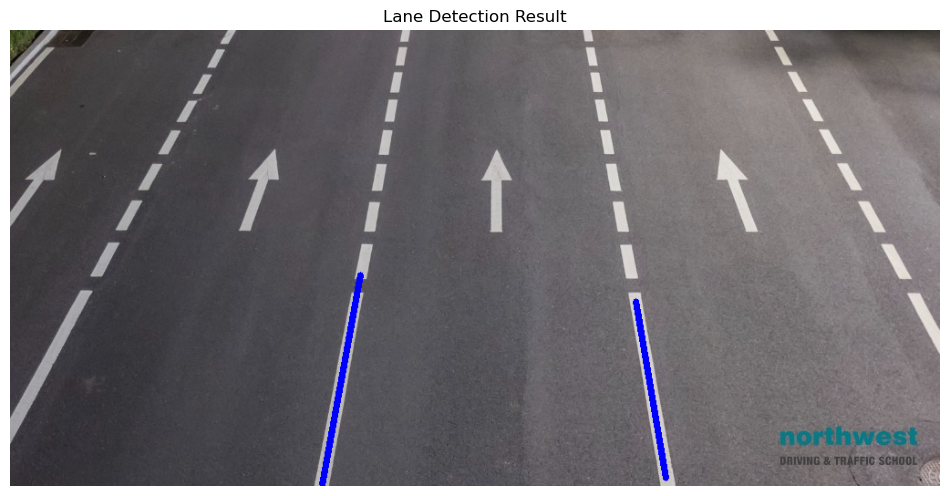

 Saved output as output_lane_video.avi


In [3]:
# -------------------- RUN THE FUNCTION --------------------

# Replace this with your image or video file
# Example: detect_lanes("/mnt/data/image.png")
# Example: detect_lanes("C:/Users/YourName/Downloads/lane_video.mp4")

detect_lanes(r"C:\Users\soumy\Downloads\Lane-Markings.jpg")

detect_lanes(r"C:\Users\soumy\Downloads\lane video.mp4")